# Stem Cell Model

From Brady et al.

This model distinguishes between prostate cancer stem-like ($S$) and differentiated ($D$) cells to model the tumor response to treatment. Stem-like cells divide at rate $\lambda$, to produce either two stem-like cells (with probability $p_{s}$, but subject to negative feedback $\frac{S}{S+D}$ from differentiated cells), or a stem-like and a non-stem cell. While stem-like cells are androgen-independent and hence do not respond to treatment, differentiated cells die in response to drug application $T_{x}$ at rate $d_{D}$.

$$
    \frac{dS}{dt} =  \left(\frac{S}{S+D}\right) p_{S} \lambda S, \\\\
    \frac{dD}{dt} = \left(1 - \frac{S}{S+D} p_{S}\right) \lambda S - d_{D} T_{x} D
$$

In [37]:
import sys
import numpy as np
import matplotlib.pyplot as plt


sys.path.append("../utils")
from odeModels import StemCellModel, StemCellModel2
from plotUtils import PlotSimulation


In [38]:
# Defaults for plotting
plt.style.use(["classic", "../utils/paper.mplstyle"])
plt.rcParams['font.size'] = '18'

colors = {'Sensitive': '#4c9150', 'Resistant': '#a80303', 'CT':'#c28d32' , 'AT':'#143159' ,'DRL_Monthly':'#66419e'}

In [39]:
# Patient 1002 - TTP ~ 3000 days
stemParamDic2 = {'rR': np.log(2),'beta': 0.025, 'dR': 0.4852,  # Cell params
                'rho': 0.0025, 'phi': 0.0167, 'DMax': 1,  # PSA/Drug params
                'S0': 1000, 'R0': 10, 'P0': 58.57}  # Initial conditions
# Patient 1005 - TTP ~ 3000 days
stemParamDic5 = {'rR': np.log(2),'beta': 0.0276, 'dR': 0.3205,  # Cell params
                'rho': 0.0016, 'phi': 0.0068, 'DMax': 1,  # PSA/Drug params
                'S0': 1000, 'R0': 10, 'P0': 95.86}  # Initial conditions
# Patient 1010 - TTP ~ 300 days
stemParamDic10 = {'rR': np.log(2),'beta': 0.3332, 'dR': 0.0958,  # Cell params
                'rho': 6.548e-5, 'phi': 0.0028, 'DMax': 1,  # PSA/Drug params
                'S0': 1000, 'R0': 10, 'P0': 17.33}  # Initial conditions
# Patient 1014 - TTP ~ 2000 days
stemParamDic14 = {'rR': np.log(2),'beta': 0.0425, 'dR': 0.0478,  # Cell params
                'rho': 1.243e-04, 'phi': 0.0113, 'DMax': 1,  # PSA/Drug params
                'S0': 1000, 'R0': 10, 'P0': 11.83}  # Initial conditions
# Patient 1018 - TTP ~ 800 days
stemParamDic18 = {'rR': np.log(2),'beta': 0.1208, 'dR': 0.2083,  # Cell params
                'rho': 4.931e-04, 'phi': 0.0149, 'DMax': 1,  # PSA/Drug params
                'S0': 1000, 'R0': 10, 'P0': 36.54}  # Initial conditions

## CT Simulations

Mean TTP for Stem Cell Model under Continuous Therapy is 1099 days


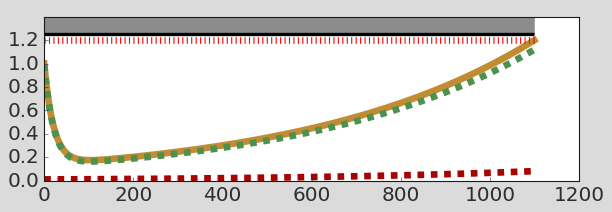

In [40]:
fig, ax = plt.subplots(1,1,figsize=(8,3))
stemParamDic = stemParamDic14
stemParamDic['N0'] = stemParamDic['S0'] + stemParamDic['R0']
stemParamDic['P0'] = 0; stemParamDic['rho'] = 0; stemParamDic['phi'] = 0

model = StemCellModel(method='Radau', dt = 1)
model.SetParams(**stemParamDic)
model.Simulate_AT(atThreshold=0.05, intervalLength=1, t_end=10000)
model.Trim(dt=1)
model.resultsDf[['TumourSize', 'S', 'R']] /= (stemParamDic['S0'] + stemParamDic['R0'])
model.resultsDf = model.resultsDf[model.resultsDf.TumourSize < 1.2]

print(f"Mean TTP for Stem Cell Model under Continuous Therapy is {max(model.resultsDf.Time):.0f} days")

palette = {'TumourSize': colors["CT"], 'S': colors['Sensitive'], 'R': colors['Resistant']}
PlotSimulation(model.resultsDf, ax=ax, legend=False, colors = palette, linewidth = 6)

# plt.savefig("figures/figSI_SC_AT.pdf")

### Predict sub-populations (no drug)

In [41]:
def synthetic_R_pop(t, beta, rR, N_star, N0, R0, **kwargs):
    return R0 / (1 - beta * rR * (2 * R0 / (N_star + N0)) * t)

def synthetic_S_pop(t, beta, rR, N_star, N0, R0, **kwargs):
    bracket = 1 - beta * rR * t * (2 * R0 / (N_star + N0))
    return N0 * (1 - np.log(bracket) / beta)


Mean TTP for Stem Cell Model under Continuous Therapy is 28 days


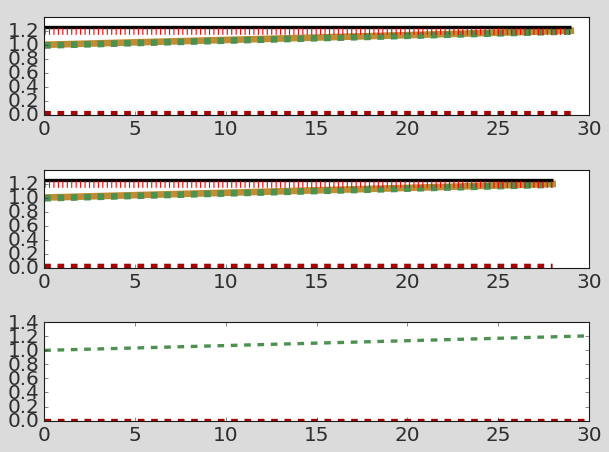

In [42]:
fig, axs = plt.subplots(3,1,figsize=(8,6))
stemParamDic = stemParamDic14
stemParamDic['N0'] = stemParamDic['S0'] + stemParamDic['R0']

palette = {'TumourSize': colors["CT"], 'S': colors['Sensitive'], 'R': colors['Resistant']}

for i, modelclass in enumerate([StemCellModel, StemCellModel2]):
    model = modelclass(method='Radau', dt = 1)
    model.SetParams(**stemParamDic)
    # model.Simulate([[0, 3000, 1]])
    model.Simulate_AT(atThreshold=2, intervalLength=1, t_end=10000)
    # model.Trim(dt=1)
    model.resultsDf[['TumourSize', 'S', 'R']] /= (stemParamDic['S0'] + stemParamDic['R0'])
    model.resultsDf = model.resultsDf[model.resultsDf.TumourSize < 1.2]
    
    PlotSimulation(model.resultsDf, ax=axs[i], legend=False, colors = palette, linewidth = 6)

t_span = np.linspace(0, axs[1].get_xlim(), 100) 
axs[2].plot(t_span, synthetic_R_pop(t_span, N_star=stemParamDic['N0'], **stemParamDic)/stemParamDic['N0'], color=colors['Resistant'], linestyle='--', linewidth=3)
axs[2].plot(t_span, synthetic_S_pop(t_span, N_star=stemParamDic['N0'], **stemParamDic)/stemParamDic['N0'], color=colors['Sensitive'], linestyle='--', linewidth=3)

print(f"Mean TTP for Stem Cell Model under Continuous Therapy is {max(model.resultsDf.Time):.0f} days")


In [43]:
# Can the analytic expression predict the progression threshold from the initial size and growth time
# Does the solver then correctly extract this time given the progression threshold and initial size?

print(synthetic_S_pop(30, N_star=stemParamDic['N0'], **stemParamDic) / stemParamDic['N0'])

1.2067913514889557


## AT Simulations

Mean TTP for Stem Cell Model under Adaptive Therapy is 2125 days


(0.0, 2500.0)

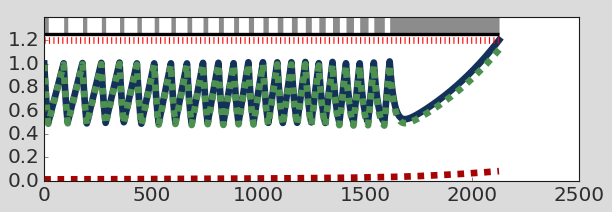

In [44]:
fig, ax = plt.subplots(1,1,figsize=(8,3))

model = StemCellModel(method='Radau', dt = 1)
model.SetParams(**stemParamDic)
model.Simulate_AT(atThreshold=0.5, intervalLength=1, t_end=10000)
model.Trim(dt=1)
model.resultsDf[['TumourSize', 'S', 'R']] /= (stemParamDic['S0'] + stemParamDic['R0'])
model.resultsDf = model.resultsDf[model.resultsDf.TumourSize < 1.2]

print(f"Mean TTP for Stem Cell Model under Adaptive Therapy is {max(model.resultsDf.Time):.0f} days")

palette = {'TumourSize': colors["AT"], 'S': colors['Sensitive'], 'R': colors['Resistant']}
PlotSimulation(model.resultsDf, ax=ax, legend=False, colors = palette, linewidth = 6)

ax.set_xlim(0, 2500)

Mean TTP for Stem Cell Model under Adaptive Therapy is 833 days


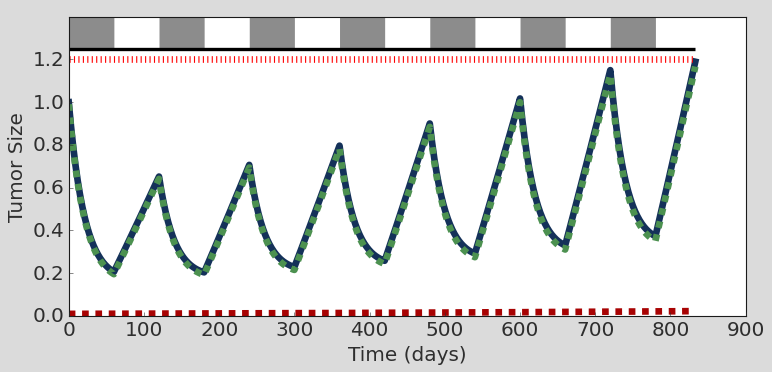

In [45]:
fig, ax = plt.subplots(1,1,figsize=(10,5))

model = StemCellModel(method='Radau', dt = 1)
model.SetParams(**stemParamDic)
model.Simulate_AT(atThreshold=0.6, atMethod='Threshold',
                    intervalLength=60, t_end=1500, refSize = stemParamDic['N0'])
model.Trim(dt=1)
model.resultsDf[['TumourSize', 'S', 'R']] /= (stemParamDic['S0'] + stemParamDic['R0'])
model.resultsDf = model.resultsDf[model.resultsDf.TumourSize < 1.2]

print(f"Mean TTP for Stem Cell Model under Adaptive Therapy is {max(model.resultsDf.Time):.0f} days")

plt.xlabel("Time (days)"); plt.ylabel("Tumor Size")
palette = {'TumourSize': colors["AT"], 'S': colors['Sensitive'], 'R': colors['Resistant']}
PlotSimulation(model.resultsDf, ax=ax, legend=False, colors = palette, linewidth = 6)
plt.savefig("../figures/stem_cell_model_progression_example")

In [46]:
def calc_ttp(params, n_crit, interval):
    model = StemCellModel(method='Radau', dt = 1); model.SetParams(**params)
    model.Simulate_AT(atThreshold=n_crit, atMethod='Threshold',
                    intervalLength=interval, t_end=1500, refSize = params['N0'])
    model.resultsDf = model.resultsDf[model.resultsDf.TumourSize < 1.2 * params['N0']]
    return model.resultsDf.Time.max()

## Predicting stem cell population growth

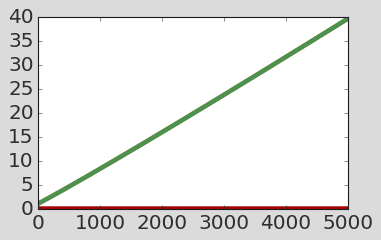

In [47]:
fig, ax = plt.subplots(1,1,figsize=(5,3))

model = StemCellModel(method='Radau', dt = 1)
model.SetParams(**stemParamDic)
model.Simulate([[0, 5000, 0]])
# model.Simulate_AT(atThreshold=0.5, intervalLength=1, t_end=10000)
model.Trim(dt=1)
model.resultsDf[['TumourSize', 'S', 'R']] /= (stemParamDic['S0'] + stemParamDic['R0'])

plt.plot(model.resultsDf.Time, model.resultsDf.TumourSize, color=colors['CT'], linewidth=4)
plt.plot(model.resultsDf.Time, model.resultsDf.S, color=colors['Sensitive'], linewidth=4)
plt.plot(model.resultsDf.Time, model.resultsDf.R, color=colors['Resistant'], linewidth=4)

Okay so this does look pretty linear. But can we predict the gradient?

Final y value is 39.57681285


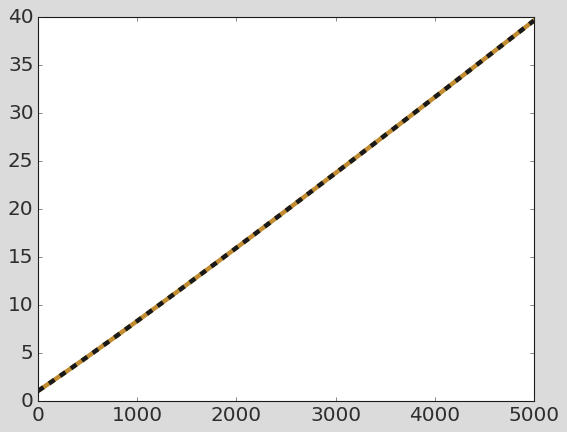

In [48]:
def predict_Nt(t, beta, rR, N0, R0, **kwargs):
    return ((rR * (1 - beta) * R0 * t) / (N0 ** beta) + N0 ** (1-beta) ) ** (1 / (1-beta))


y_vals = [predict_Nt(t, **stemParamDic) / stemParamDic['N0'] for t in model.resultsDf.Time.values]
print(f"Final y value is {y_vals[-1]:.8f}")

plt.plot(model.resultsDf.Time, model.resultsDf.TumourSize, color=colors['CT'], linewidth=4)
plt.plot(model.resultsDf.Time, y_vals, color='k', linestyle='--', linewidth=4);

Final y value is 39.57681285


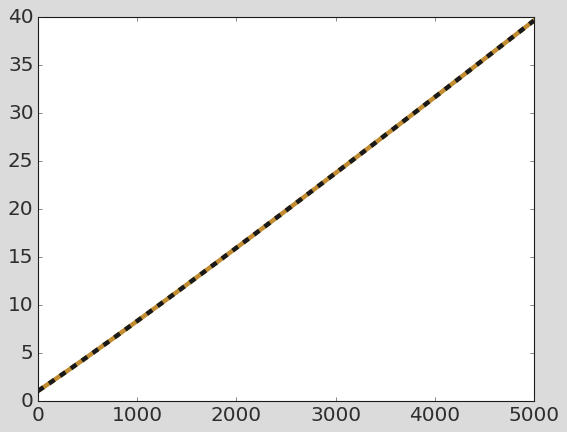

In [49]:
# To check - we can also predict the tumour size from the R population directly

def predict_Nt(R, beta, N0, R0, **kwargs):
    # print((1/ R0) ** (1 / beta))
    return N0 * (R/ R0) ** (1 / beta)

y_vals = [predict_Nt(R , **stemParamDic) / stemParamDic['N0'] for R in model.resultsDf.R.values * stemParamDic['N0'] ]
print(f"Final y value is {y_vals[-1]:.8f}")

# plt.ylim(0, 10)


plt.plot(model.resultsDf.Time, model.resultsDf.TumourSize, color=colors['CT'], linewidth=4)
plt.plot(model.resultsDf.Time, y_vals, color='k', linestyle='--', linewidth=4);

### Check accuracy of stem cell population prediction

In [24]:
def calc_stem_cell_pop(t, R0, beta, rR, N0, **kwargs):
    denominator = 1 - beta * rR * t * (R0 / (1.0 * N0))
    return R0 / denominator

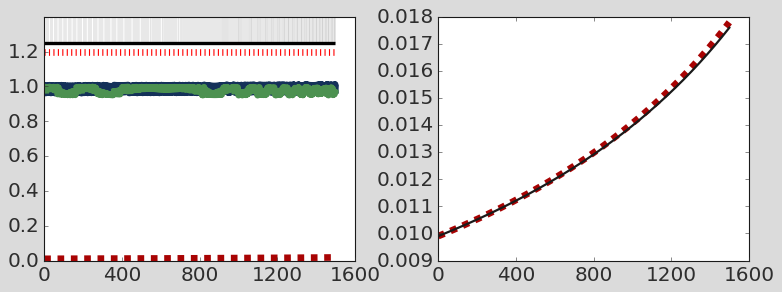

In [25]:
# Stem cell population only prediction
fig, axs = plt.subplots(1, 2,figsize=(10,4))

interval_lengths = [40, 47, 48]

stemParamDic['N0'] = stemParamDic['S0'] + stemParamDic['R0']
model = StemCellModel(method='Radau', dt = 1)
model.SetParams(**stemParamDic)
model.Simulate_AT(atThreshold=1, atMethod='Threshold', t_end=1500,
                    intervalLength=1, refSize = stemParamDic['N0'])
model.Trim(dt=1)
model.resultsDf[['TumourSize', 'S', 'R']] /= (stemParamDic['S0'] + stemParamDic['R0'])
model.resultsDf = model.resultsDf[model.resultsDf.TumourSize < 1.2]

PlotSimulation(model.resultsDf, ax=axs[0], legend=False, colors = palette, linewidth = 6)

axs[1].plot(model.resultsDf.Time, model.resultsDf.R, color=colors['Resistant'], linewidth=6, linestyle='--')

predicted_St = [calc_stem_cell_pop(t, **stemParamDic) / stemParamDic['N0'] for t in model.resultsDf.Time.values]
axs[1].plot(model.resultsDf.Time, predicted_St, color='k', linewidth=2)

axs[0].set_xticks(axs[0].get_xticks()[::2]); axs[1].set_xticks(axs[1].get_xticks()[::2]);

## Examples of specific AT protocol failures

Final Stem Cell population is 0.0806, drug state is 1
Final Stem Cell population is 0.0806, drug state is 1
Final Stem Cell population is 0.0255, drug state is 0


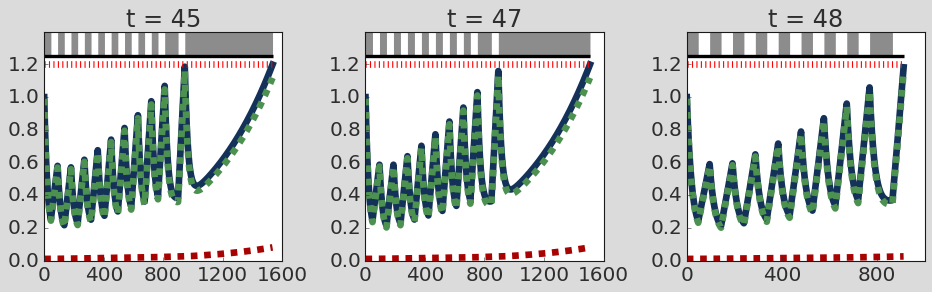

In [30]:
fig, axs = plt.subplots(1, 3,figsize=(12,4))

interval_lengths = [45, 47, 48]

for n, ax in enumerate(axs):
    stemParamDic['N0'] = stemParamDic['S0'] + stemParamDic['R0']
    model = StemCellModel(method='Radau', dt = 1)
    model.SetParams(**stemParamDic)
    model.Simulate_AT(atThreshold=0.4, atMethod='Threshold', t_end=2000,
                        intervalLength=interval_lengths[n], refSize = stemParamDic['N0'])
    model.Trim(dt=1)
    model.resultsDf[['TumourSize', 'S', 'R']] /= (stemParamDic['S0'] + stemParamDic['R0'])
    model.resultsDf = model.resultsDf[model.resultsDf.TumourSize < 1.2]

    PlotSimulation(model.resultsDf, ax=ax, legend=False, colors = palette, linewidth = 6)
    ax.set_xticks(ax.get_xticks()[::2]); ax.set_title(f"t = {interval_lengths[n]}")

    print(f"Final Stem Cell population is {model.resultsDf.R.values[-1]:.4f}"
          + f", drug state is {model.resultsDf.DrugConcentration.values[-1]:.0f}")

plt.tight_layout(); 
# plt.savefig("../figures/stem_cell_model_progression_example2"); plt.show()

### Time varying threshold

In [31]:
from scipy.optimize import fsolve

def N_star_function(N_star, tau, Rt, beta, rR, prog, **_args):
    frac = rR * (1 - beta) * Rt * tau / (N_star ** beta)
    return frac + N_star ** (1-beta) - prog ** (1-beta)


In [32]:
import warnings
warnings.simplefilter('error', RuntimeWarning)

prog = stemParamDic['N0'] * 1.2

def compute_threshold(tau, t, R_t, params):
    def N_star_wrapper(N_star):
        return N_star_function(N_star, tau=tau, Rt=R_t, prog=prog, **params)
    
    try:
        return fsolve(N_star_wrapper, params['N0'])[0]
    except RuntimeWarning:
        return 0

In [33]:
tau = 40
def variable_threshold(df_row, refSize, t):
    threshold = compute_threshold(tau, t, df_row.R, stemParamDic)
    if threshold == 0 or np.isnan(threshold):
        return 1
    return df_row.TumourSize > threshold 

In [34]:
print(palette)
palette['TumourSize'] = 'k'

{'TumourSize': '#143159', 'S': '#4c9150', 'R': '#a80303'}


TTP for Stem Cell Model under Fixed Threshold is 1077 days
TTP for Stem Cell Model under Variable Threshold is 1839 days


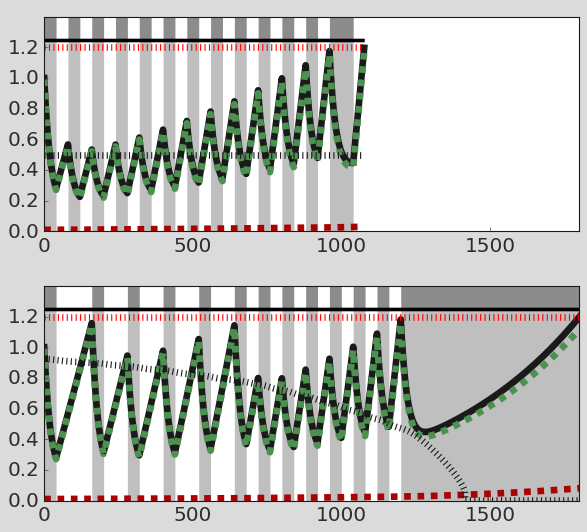

In [36]:
from plotUtils import PlotDrug

fig, axs = plt.subplots(2, 1, figsize=(8, 7))

# Simulate model with fixed threshold
stemParamDic['N0'] = stemParamDic['S0'] + stemParamDic['R0']
model = StemCellModel(method='Radau', dt = 1)
model.SetParams(**stemParamDic)
model.Simulate_AT(atThreshold=0.5, atMethod='Threshold', t_end=2000,
                    intervalLength=tau, refSize = stemParamDic['N0'])
model.Trim(dt=1)
model.resultsDf[['TumourSize', 'S', 'R']] /= (stemParamDic['S0'] + stemParamDic['R0'])
model.resultsDf = model.resultsDf[model.resultsDf.TumourSize < 1.2]
print(f"TTP for Stem Cell Model under Fixed Threshold is {max(model.resultsDf.Time):.0f} days")

PlotSimulation(model.resultsDf, ax=axs[0], legend=False, colors = palette, linewidth = 6)
PlotDrug(model.resultsDf, axs[0], 'gray', plotDrugAsBar = True, currDrugBarPosition = -0.05,
         drugBarHeight = 1.3)
axs[0].hlines(y=0.5, xmin=0, xmax=max(model.resultsDf.Time), 
              color='k', linestyle=':', linewidth=6, zorder=10)

# Simulate model with time varying threshold
stemParamDic['N0'] = stemParamDic['S0'] + stemParamDic['R0']
model = StemCellModel(method='Radau', dt = 1)
model.SetParams(**stemParamDic)
model.Simulate_AT(atThreshold=0.5, atMethod='Custom', atFunc=variable_threshold, t_end=2000,
                    intervalLength=tau, refSize = stemParamDic['N0'])
model.Trim(dt=1)
print(f"TTP for Stem Cell Model under Variable Threshold is {max(model.resultsDf.Time):.0f} days")

# Plot the variable threshold over time
threshold_vals = [compute_threshold(tau=tau, t=t, R_t=R_t, params=stemParamDic) / stemParamDic['N0'] 
                  for t, R_t in zip(model.resultsDf.Time.values, model.resultsDf.R.values)]
axs[1].plot(model.resultsDf.Time, threshold_vals, color='k', linewidth=6, 
            linestyle=':', zorder=10)

model.resultsDf[['TumourSize', 'S', 'R']] /= (stemParamDic['S0'] + stemParamDic['R0'])
model.resultsDf = model.resultsDf[model.resultsDf.TumourSize < 1.2]

PlotSimulation(model.resultsDf, ax=axs[1], legend=False, colors = palette, linewidth = 6)
PlotDrug(model.resultsDf, axs[1], 'gray', plotDrugAsBar = True, currDrugBarPosition = -0.05,
         drugBarHeight = 1.3)


# axs[0].set_xticks(axs[0].get_xticks()[::4]); axs[1].set_xticks(axs[1].get_xticks()[::2]);
axs[0].set_xlim(0, max(model.resultsDf.Time)); axs[1].set_xlim(0, max(model.resultsDf.Time)); 
plt.savefig("../figures/stem_cell_model_progression_example.pdf"); plt.show()

Can be clearer to visualise this with discrete intervals marked:

Final Stem Cell population is 0.0806, drug state is 1, and predicted failure is True
Final Stem Cell population is 0.0806, drug state is 1, and predicted failure is False
Final Stem Cell population is 0.0255, drug state is 0, and predicted failure is True


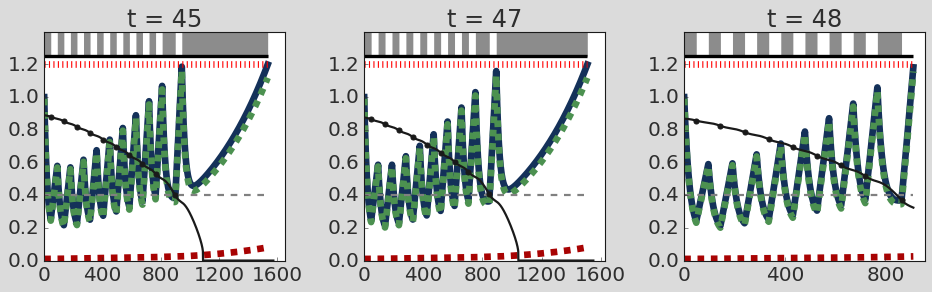

In [103]:
fig, axs = plt.subplots(1, 3,figsize=(12,4))

interval_lengths = [45, 47, 48]

for n, ax in enumerate(axs):
    stemParamDic['N0'] = stemParamDic['S0'] + stemParamDic['R0']
    model = StemCellModel(method='Radau', dt = 1)
    model.SetParams(**stemParamDic)
    model.Simulate_AT(atThreshold=0.4, atMethod='Threshold', t_end=2000,
                        intervalLength=interval_lengths[n], refSize = stemParamDic['N0'])
    model.Trim(dt=1)

    threshold_vals = [compute_threshold(tau=interval_lengths[n], t=t, R_t=R_t, 
                                        params=stemParamDic) / stemParamDic['N0'] 
                  for t, R_t in zip(model.resultsDf.Time.values, model.resultsDf.R.values)]
    ax.plot(model.resultsDf.Time, threshold_vals, color='k', linewidth=2, zorder=10)

    N_init = (stemParamDic['S0'] + stemParamDic['R0'])
    model.resultsDf[['TumourSize', 'S', 'R']] /= N_init
    model.resultsDf = model.resultsDf[model.resultsDf.TumourSize < 1.2]

    PlotSimulation(model.resultsDf, ax=ax, legend=False, colors = palette, linewidth = 6)
    ax.set_xticks(ax.get_xticks()[::2]); ax.set_title(f"t = {interval_lengths[n]}")

    ax.hlines(0.4, xmin=0, xmax=model.resultsDf.Time.max(),
            color='gray', linestyle='--', linewidth=2)
    
    time_points = model.resultsDf[(model.resultsDf.Time % interval_lengths[n] == 0)
                                  & (model.resultsDf.DrugConcentration == 0)].Time.tolist()
    threshold_points = [compute_threshold(tau=interval_lengths[n], t=t, R_t=R_t * N_init, 
                                        params=stemParamDic) / stemParamDic['N0'] 
                  for t, R_t in zip(time_points, model.resultsDf[model.resultsDf.Time.isin(time_points)].R.values)]
    ax.scatter(time_points, threshold_points, color='k', s=20, zorder=10)
    failure = any(val < 0.4 for val in threshold_points)
        
    print(f"Final Stem Cell population is {model.resultsDf.R.values[-1]:.4f}"
          + f", drug state is {model.resultsDf.DrugConcentration.values[-1]:.0f}"
          + f", and predicted failure is {failure}")
    ax.set_xlim(left=0)

# print(time_points)
# print(threshold_points)
# model.resultsDf.to_csv("test_results.csv")

plt.tight_layout(); 
# plt.savefig("../figures/stem_cell_model_progression_example2"); plt.show()